## Hierarchical Agent Teams

For this example, we encapsulate the functionality for [LangChain's Hierarchical Agent Teams](https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/hierarchical_agent_teams.ipynb) in a [HierarchicalAgentTeams](../../../../../slangchain/graphs/anthropic/multi_agent/hierarchical_agent_teams.py) class to orchestrate a list of [AgentTeam](../../../../../slangchain/graphs/anthropic/schemas.py).


In our previous example ([Agent Supervisor](./agent_supervisor.ipynb)), we introduced the concept of a single supervisor node to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed _hierarchically_.

You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.

To do this, let's build a simple research assistant! The graph will look something like the following:

![diagram](./img/hierarchical-diagram.png)

This notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al. In the rest of this notebook, you will:

1. Define the agents' tools to access the web and write files
2. Define some utilities to help create the graph and agents
3. Create and define each team (web research + doc writing)
4. Compose everything together.

But before all of that, some setup:

In [1]:
# %%capture --no-stderr
# %pip install -U langgraph langchain langchain_openai langchain_experimental

In [3]:
import getpass
import os
import uuid


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass(f"Please provide your {var}")


_set_if_undefined("ANTHROPIC_API_KEY")
_set_if_undefined("TAVILY_API_KEY")


## Create Tools

Each team will be composed of one or more agents each with one or more tools. Below, define all the tools to be used by your different teams.

We'll start with the research team.

**Research team tools**

The research team can use a search engine and url scraper to find information on the web. Feel free to add additional functionality below to boost the team performance!

In [4]:
from typing import Annotated, List, Tuple, Union

import matplotlib.pyplot as plt
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langsmith import trace

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

**Document writing team tools**

Next up, we will give some tools for the doc writing team to use.
We define some bare-bones file-access tools below.

Note that this gives the agents access to your file-system, which can be unsafe. We also haven't optimized the tool descriptions for performance.

In [5]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Succesfully executed:\n```python\n{code}\n```\nStdout: {result}"

## Define Agent Teams

Now we can get to define our hierachical teams. "Choose your player!"

We use the [`AgentTeamToolsNode`](../../../../../slangchain/graphs/anthropic/schemas.py) and [`AgentTeam`](../../../../../slangchain/graphs/anthropic/schemas.py) classes to organize tools used by an agent team in a hierarchical structure.

### AgentTeamToolsNode Class

This class represents a node in the hierarchical structure. It contains the following attributes:

- `prelude`: An optional callable function to execute before the agent's actions.
- `name`: A string representing the name of the node.
- `tools`: A sequence of `BaseTool` instances representing the tools associated with this node.
- `prompt`: A string containing a prompt message for this node.

#### Methods:

- `from_objs`: A class method that constructs an instance of `AgentTeamToolsNode` from given objects, including the name, tools, prompt message, and an optional prelude function.


### AgentTeam Class

This class represents the overall agent team and contains the following attributes:

- `name`: Name of the agent team.
- `agent_state`: Type of the agent's state.
- `tools_nodes`: Sequence of `AgentTeamToolsNode` instances representing nodes containing tools.

#### Methods:

- `from_objs`: A class method that constructs an instance of `AgentTeam` from given objects, including the name, agent state type, and a sequence of `AgentTeamToolsNode` instances.

### Research Team

The research team will have a search agent and a web scraping "research_agent" as the two worker nodes. Let's create those, as well as the team supervisor.

In [6]:
import operator

from langchain_core.messages import AIMessage, BaseMessage
from slangchain.graphs.anthropic.schemas import AgentTeamToolsNode, AgentTeam

# Research team graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str

search_tool_node = AgentTeamToolsNode.from_objs(
    name = "Search",
    tools = [ tavily_tool ],
    prompt= "You are a research assistant who can search for up-to-date info using the tavily search engine."
)

research_tool_node = AgentTeamToolsNode.from_objs(
    name = "Web Scraper",
    tools = [ scrape_webpages ],
    prompt= "You are a research assistant who can scrape specified urls for more detailed information using the scrape_webpages function."
)

research_team = AgentTeam.from_objs(
    name = "Research team",
    agent_state = ResearchTeamState,
    tools_nodes = [ search_tool_node, research_tool_node ],
)


### Document Writing Team

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

Note that we are giving file-system access to our agent here, which is not safe in all cases.

With the objects themselves created, we can form the graph.

In [7]:
# Document writing team graph state
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str

# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


doc_writing_node = AgentTeamToolsNode.from_objs(
    name = "Doc Writer",
    tools = [ write_document, edit_document, read_document ],
    prompt= (
      "You are an expert writing a research document.\n"
      "Below are files currently in your directory:\n{current_files}"
    ),
    prelude = prelude
)

note_taking_node = AgentTeamToolsNode.from_objs(
    name = "Note Taker",
    tools = [ create_outline, read_document ],
    prompt= (
      "You are an expert senior researcher tasked with writing a paper outline and"
      " taking notes to craft a perfect paper. {current_files}"
    ),
    prelude = prelude
)

chart_generating_node = AgentTeamToolsNode.from_objs(
    name = "Chart Generator",
    tools = [ read_document, python_repl ],
    prompt= (
      "You are a data viz expert tasked with generating charts for a research project."
      "{current_files}"
    ),
    prelude = prelude
)

doc_writing_team = AgentTeam.from_objs(
    name = "Paper writing team",
    agent_state = DocWritingState,
    tools_nodes = [ doc_writing_node, note_taking_node, chart_generating_node ],
)


## HierarchicalAgentTeams

We use the [HierarchicalAgentTeams](../../../../../slangchain/graphs/anthropic/multi_agent/hierarchical_agent_teams.py) class to orchestrate a list of [AgentTeam](../../../../../slangchain/graphs/anthropic/schemas.py).

### How it works

This class orchestrates the interaction between a supervisor and multiple agent teams within a hierarchical structure. It manages the flow of conversation and tasks among the teams.

1. **`__init__`: 
   - Initializes an instance of `HierarchicalAgentTeams`.
   - Parameters include the model name, agent teams, and various configuration options.

1. **`from_agent_teams`:
   - A class method that constructs an instance of `HierarchicalAgentTeams` from a sequence of agent teams.

1. **`init_workflow_nodes`:
   - Initializes the workflow nodes for the chain.
   - Sets up the structure of the conversation flow, including the supervisor node and agent team nodes.

1. **`_call`:
   - Executes the chain based on the input message.
   - Initializes the workflow nodes, compiles the workflow into a graph, and executes the graph using a stream processing approach.
   - Manages the flow of conversation and tasks among the teams until reaching an end state.

1. **`_create_tools_agent`:
   - Creates an agent that uses Anthropic tools for a given set of tools and a prompt.

1. **`_create_agent_team_executor`:
   - Creates an executor for an agent team.
   - Sets up the agent, tools, and other parameters for execution within an agent team.

1. **`_create_team_supervisor`:
   - Creates a supervisor node with the specified model name and team members.
   - Sets up the supervisor node for interaction with agent teams.

1. **`_create_team_tools_node`:
   - Creates a node for an agent team with the specified agent node, tools, and prompt.
   - Sets up the node for executing tasks within an agent team.

1. **`_create_agent_team_graph`:
   - Creates a graph for an agent team chain.
   - Defines nodes for supervisor and agent team members and defines the edges between them.

1. **`_create_agent_team_chain`:
    - Creates a chain for an agent team.
    - Sets up the workflow and graph for execution within an agent team.

1. **`_get_last_message`:
    - Retrieves the last message from the agent state.
    - Used for processing and logging messages during the conversation.

1. **`_join_graph`:
    - Joins the graph response to produce the final output.
    - Formats and aggregates the messages exchanged during the conversation.

1. **`_enter_chain`:
    - Enters the chain function and logs the message and team members.
    - Used for processing and managing the flow of conversation within the chain.

### Flow of the Class:

1. **Initialization**:
   - The class is initialized with parameters such as model name, agent teams, and configuration options.

1. **Workflow Initialization**:
   - The `init_workflow_nodes` method sets up the structure of the conversation flow, including supervisor and agent team nodes.

1. **Execution**:
   - When `_call` is invoked, it initializes the workflow nodes, compiles the workflow into a graph, and executes the graph using a stream processing approach.

1. **Agent Team Management**:
   - For each agent team, a chain is created, which includes setting up the workflow and graph for execution.

1. **Supervisor Interaction**:
   - The supervisor interacts with each agent team, delegating tasks and managing the flow of conversation.

1. **Message Processing**:
   - Messages are exchanged between the supervisor and agent teams, and tasks are executed within each team according to the predefined workflow.

1. **Completion**:
   - The execution continues until it reaches an end state, at which point the final output is obtained.

1. **Return**:
   - The final output, containing the messages exchanged during the conversation, is returned as the result of the `_call` method.



In [8]:
import sys
import logging

stream_handler = logging.StreamHandler(sys.stdout)
logger = logging.getLogger()


logger.setLevel(logging.INFO)
logger.addHandler(stream_handler)

In [9]:
from slangchain.graphs.anthropic.multi_agent.hierarchical_agent_teams import HierarchicalAgentTeams

hierarchical_agent_teams = HierarchicalAgentTeams.from_agent_teams(
  agent_teams = [ research_team, doc_writing_team ]
)

In [10]:
print(WORKING_DIRECTORY)

/var/folders/8y/bs83mhtn1ld238czv2s5sj900000gn/T/tmpgfswbni3


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `bind_tools` is in beta. It is actively being worked on, so the API may change.
  warn_beta(



{'supervisor': {'next': 'Research team'}}
----

{'Research team': {'messages': [HumanMessage(content='<result>\nNorth American Sturgeon Overview:\n\nThere are several species of sturgeon found in North America, including:\n\n- Atlantic Sturgeon (Acipenser oxyrinchus oxyrinchus): Found along the Atlantic coast from Canada to Florida. They can grow up to 15 feet long and weigh over 800 pounds.\n- White Sturgeon (Acipenser transmontanus): The largest sturgeon species in North America, found along the Pacific coast from Alaska to California. They can reach over 15 feet in length and weigh up to 1,800 pounds.\n- Lake Sturgeon (Acipenser fulvescens): Found in the Great Lakes region and rivers that flow into the Hudson Bay. They typically grow 3-6 feet long.\n- Pallid Sturgeon (Scaphirhynchus albus): A critically endangered species found in the Missouri and Mississippi River basins.\n\nSturgeon are bottom-dwelling fish that primarily feed on invertebrates and small fish. They have unique fea

<Figure size 1000x600 with 0 Axes>

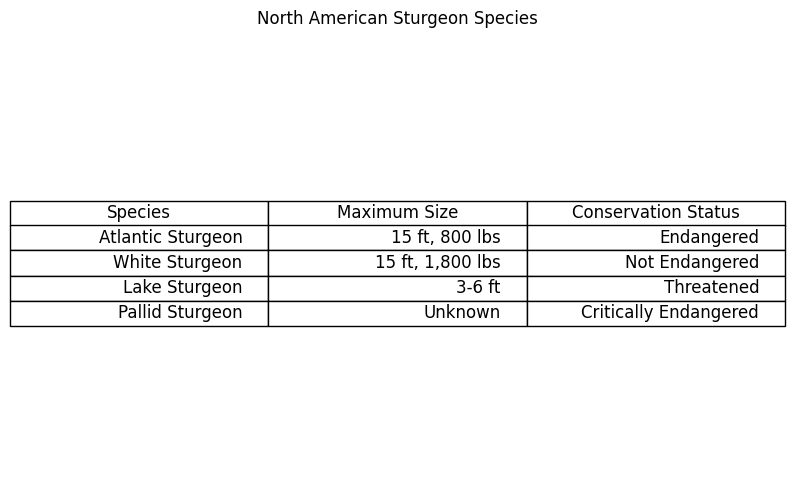


{'Paper writing team': {'messages': [HumanMessage(content='The resulting chart is a table displaying the key information about the different North American sturgeon species, including their maximum size and conservation status. This provides a clear and concise overview of the sturgeon populations in an easy-to-read format.', name='Chart Generator')]}}
----

{'supervisor': {'next': 'Paper writing team'}}
----

{'Paper writing team': {'messages': [HumanMessage(content='The resulting chart is a table displaying the key information about the different North American sturgeon species, including their maximum size and conservation status. This provides a clear and concise overview of the sturgeon populations in an easy-to-read format.')]}}
----

{'supervisor': {'next': 'Paper writing team'}}
----

{'Paper writing team': {'messages': [HumanMessage(content='The resulting chart is a table displaying the key information about the different North American sturgeon species, including their maxim

{'input': 'Write a brief research report on the North American sturgeon. Include a chart.',
 'output': {'messages': [HumanMessage(content=[{'type': 'text', 'text': 'Write a brief research report on the North American sturgeon. Include a chart.'}, {'type': 'text', 'text': '<result>\nNorth American Sturgeon Overview:\n\nThere are several species of sturgeon found in North America, including:\n\n- Atlantic Sturgeon (Acipenser oxyrinchus oxyrinchus): Found along the Atlantic coast from Canada to Florida. They can grow up to 15 feet long and weigh over 800 pounds.\n- White Sturgeon (Acipenser transmontanus): The largest sturgeon species in North America, found along the Pacific coast from Alaska to California. They can reach over 15 feet in length and weigh up to 1,800 pounds.\n- Lake Sturgeon (Acipenser fulvescens): Found in the Great Lakes region and rivers that flow into the Hudson Bay. They typically grow 3-6 feet long.\n- Pallid Sturgeon (Scaphirhynchus albus): A critically endangered 

In [11]:
hierarchical_agent_teams.invoke(input = {
  "input": (
    "Write a brief research report on the North American sturgeon."
    " Include a chart."
  )
})